In [192]:
from tqdm import tqdm
from skimage.io import imread
from skimage import color
from scipy.misc import imresize
from scipy import fftpack
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from multiprocessing import cpu_count
from concurrent.futures import ThreadPoolExecutor

%matplotlib inline
np.seterr(divide='raise')

{'divide': 'raise', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
from utils import get_labels_dict
from constants import LABELS, WEATHER_IDX
WEATHER_LABELS = [LABELS[i] for i in WEATHER_IDX]
print(LABELS)

Using TensorFlow backend.


['clear', 'cloudy', 'haze', 'partly_cloudy', 'agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'conventional_mine', 'cultivation', 'habitation', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [3]:
labels = get_labels_dict()

In [39]:
def get_images_of_tag(tag, n):
    """
    Return n image with that match the tag
    """
    idx = LABELS.index(tag)
    for k in labels:
        if labels[k][idx] == 1:
            yield k
            n -= 1
            if n ==0:
                break

In [5]:
[f for f in get_images_of_tag("artisinal_mine", 5)]

['train_36041', 'train_11536', 'train_9803', 'train_11035', 'train_17278']

In [134]:
def get_channels(img):
    """
    Return a grey scale image for each channel
    """
    w, h, d = img.shape
    res = []
    for c in range(d):
        i = np.zeros((w, h, 3))
        for k in range(3):
            i[:,:,k] = img[:,:,c]
        res.append(i)
    return np.array(res)

def show(img):
    s = img.shape
    if len(s) == 2:
        # grey scale
        img = img.reshape((s[0], s[1], 1))
        img = get_channels(img)[0]
    plt.imshow(np.asarray(img[:,:,0:3], dtype=np.uint8))
    plt.show()
    
def open_img(name):
    #return imread(name)
    #return 255 - np.asarray(Image.open(name, "r"), dtype=np.float32)[:,:,0:3]
    return 255 - np.asarray(Image.open(name, "r"), dtype=np.uint8)[:,:,0:3]

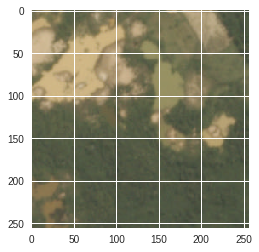

pixel 0,0 [117 108  83]


In [7]:
img = open_img("rawInput/train-jpg/train_15510.jpg")
show(img)

print("pixel 0,0", img[0,0,:])

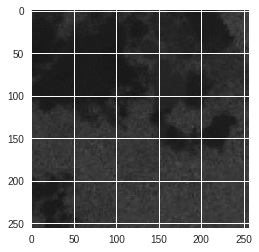

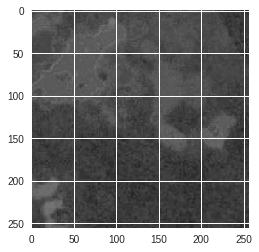

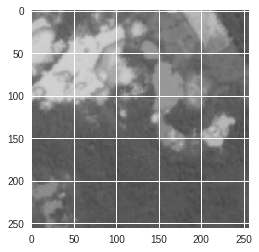

In [8]:
for i in get_channels(color.rgb2hsv(img)):
    show(i * 255)

# HSV analysis

In [30]:
img_names = np.array([k for k in labels])
sampled_imgs = []
for tag in WEATHER_LABELS:
    for i in get_images_of_tag(tag, 100):
        sampled_imgs.append(i)

sampled_labels = { k: labels[k] for k in sampled_imgs }

In [32]:
hsv = {}
process_count = cpu_count()

def get_hsv_mean(img_name):
    img = open_img("rawInput/train-jpg/{k}.jpg".format(k=img_name))
    img = color.rgb2hsv(img) * 255
    h, s, v = np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])
    tags = [LABELS[i] for i, v in enumerate(labels[img_name]) if v == 1]
    return tags, h, s, v

with ThreadPoolExecutor(process_count) as pool:
    for tags, h, s, v in tqdm(
            pool.map(
                get_hsv_mean,
                [img_name for img_name in sampled_labels]
            ),
            total=len(sampled_labels)
        ):
            for tag in tags:
                if tag not in hsv:
                    hsv[tag] = { "n": 0, "h": 0.0, "s": 0.0, "v": 0.0 }
                hsv[tag]["n"] += 1
                hsv[tag]["h"] += h
                hsv[tag]["s"] += s
                hsv[tag]["v"] += v

for tag in WEATHER_LABELS:
    hsv[tag]["s"] /= hsv[tag]["n"]
    hsv[tag]["h"] /= hsv[tag]["n"]
    hsv[tag]["v"] /= hsv[tag]["n"]
    
print("hsv", hsv)

100%|██████████| 400/400 [00:02<00:00, 179.19it/s]

hsv {'agriculture': {'s': 3389.7864964435371, 'h': 4890.263078235278, 'n': 77, 'v': 8980.774658203125}, 'artisinal_mine': {'s': 281.18675109454472, 'h': 150.74350711196686, 'n': 4, 'v': 611.27458190917969}, 'blow_down': {'s': 60.022444363156708, 'h': 63.687947921702808, 'n': 1, 'v': 81.888656616210938}, 'haze': {'s': 28.125459421611989, 'h': 78.72998140347859, 'n': 100, 'v': 125.87971374511719}, 'road': {'s': 2679.2373831783566, 'h': 3480.288329819241, 'n': 56, 'v': 6342.3345489501953}, 'partly_cloudy': {'s': 43.812064403498233, 'h': 76.077396884223347, 'n': 100, 'v': 102.22885955810547}, 'selective_logging': {'s': 274.11305760044456, 'h': 416.87853191155659, 'n': 5, 'v': 368.45591735839844}, 'clear': {'s': 60.871802421027922, 'h': 82.743331898172784, 'n': 100, 'v': 78.554731597900386}, 'conventional_mine': {'s': 32.697551622631316, 'h': 71.516518167195656, 'n': 1, 'v': 121.82315063476562}, 'cultivation': {'s': 1249.5785518291564, 'h': 1871.9956122458561, 'n': 26, 'v': 2667.34489440917

In [33]:
hsv_dist = {}

def get_hsv_mean(img_name):
    img = open_img("rawInput/train-jpg/{k}.jpg".format(k=img_name))
    img = color.rgb2hsv(img) * 255
    h, s, v = img[:,:,0], img[:,:,1], img[:,:,2]
    tags = [LABELS[i] for i, v in enumerate(labels[img_name]) if v == 1]
    return tags, h, s, v

with ThreadPoolExecutor(process_count) as pool:
    for tags, h, s, v in tqdm(
            pool.map(
                get_hsv_mean,
                [img_name for img_name in sampled_labels]
            ),
            total=len(sampled_labels)
        ):
            for tag in tags:
                if tag in WEATHER_LABELS:
                    if tag not in hsv_dist:
                        hsv_dist[tag] = { "n": 1, "h": [h], "s": [s], "v": [v] }
                    else:
                        hsv_dist[tag]["n"] += 1
                        hsv_dist[tag]["h"].append(h)
                        hsv_dist[tag]["s"].append(s)
                        hsv_dist[tag]["v"].append(v)

for tag in WEATHER_LABELS:
    hsv_dist[tag]["h"] = np.array(hsv_dist[tag]["h"]).flatten()
    hsv_dist[tag]["s"] = np.array(hsv_dist[tag]["s"]).flatten()
    hsv_dist[tag]["v"] = np.array(hsv_dist[tag]["v"]).flatten()

100%|██████████| 400/400 [00:02<00:00, 177.64it/s]


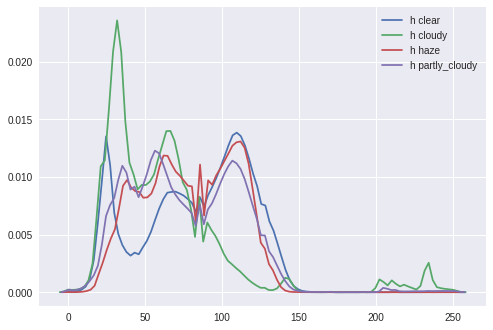

In [34]:
sns.set(color_codes=True)
for i in WEATHER_IDX:
    sns.kdeplot(hsv_dist[LABELS[i]]["h"], label="h {tag}".format(tag=LABELS[i]))
plt.legend()

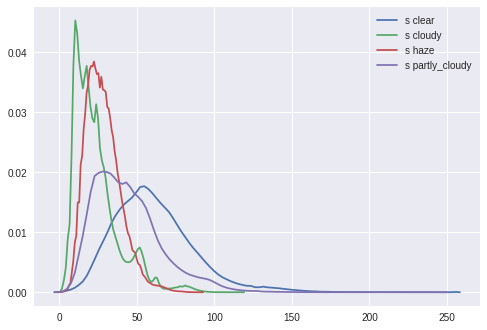

In [35]:
for i in WEATHER_IDX:
    sns.kdeplot(hsv_dist[LABELS[i]]["s"], label="s {tag}".format(tag=LABELS[i]))
plt.legend()

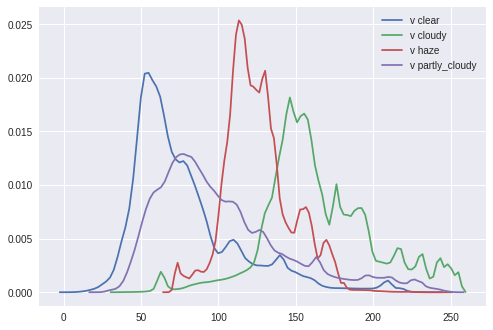

In [36]:
for i in WEATHER_IDX:
    sns.kdeplot(hsv_dist[LABELS[i]]["v"], label="v {tag}".format(tag=LABELS[i]))
plt.legend()

# Fourrier transform

In [113]:
img = np.asarray(img[:,:,0:3], dtype=np.float32)
F1 = fftpack.fft2(img)
# Now shift so that low spatial frequencies are in the center.
F2 = fftpack.fftshift(F1)
# the 2D power spectrum is:
psd2D = np.abs(F2)**2

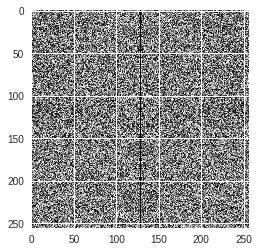

In [114]:
show(get_channels(psd2D)[1])

12.6047039032 12.6084661484


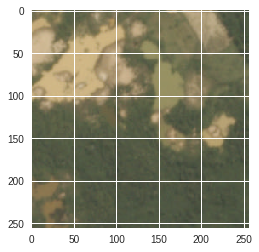

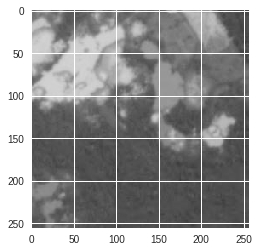

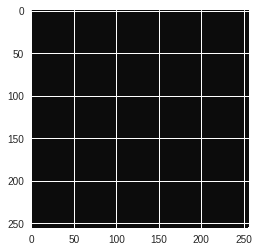

In [178]:
f = fftpack.fft2(img[:,:,0])

# img = cv2.imread('messi5.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()


w, h = f.shape
f[f > 1000000] = 0
# f = fftpack.ifft2(f)
f = np.real(f)
f = f - np.min(f) + 0.00001
f = np.log(f)
m, M = np.percentile(f, 10), np.percentile(f, 90)
print(m, M)
# f = (f - m) / (M - m)
# f = f / np.max(f) * 255.0
img[0, 0], f[0, 0]

show(img)
show(img[:,:,0])
show(f)

In [191]:
np.min(f), np.max(f), f, np.percentile(f, 0.10), np.percentile(f, 90), len(f[f < 12]), len(f[f > 13])

(-11.512925,
 13.395615,
 array([[ 12.60659313,  12.84454346,  11.5415678 , ...,  12.62805939,
          11.5415678 ,  12.84454346],
        [ 12.63700199, -11.51292515,  12.58061218, ...,  12.84162712,
          12.85782528,  13.39561462],
        [ 11.55371284,  12.91232491,  13.07421589, ...,  12.44394112,
          11.79068756,  11.63664532],
        ..., 
        [ 12.71410656,  12.3409071 ,  12.4551487 , ...,  12.24137211,
          12.34460068,  12.47381115],
        [ 11.5537138 ,  11.63664532,  11.79068756, ...,  12.4791832 ,
          13.07421589,  12.91232491],
        [ 12.63700294,  13.39561462,  12.85782528, ...,  12.54586506,
          12.58061218,  -2.77242875]], dtype=float32),
 12.457732129096986,
 12.608466148376465,
 12,
 6)

In [120]:
# (abs(posX) > w / 4.0)
F1.shape

(256, 256, 3)

oups 178 128 0
oups 204 128 0
oups 205 128 0
oups 255 128 0


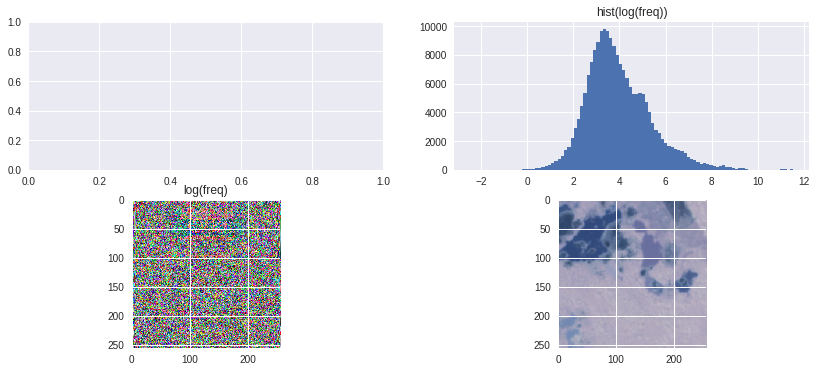

In [127]:
freq = np.abs(F1) 
# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
# ax[0,0].hist(freq.ravel(), bins=100)
# ax[0,0].set_title('hist(freq)')
for i in range(w):
    for j in range(h):
        for c in range(3):
            if freq[i, j, c] == 0:
                print("oups", i, j, c)
                freq[i, j, c] = 1
np.log(freq)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
ax[0,1].hist(np.log(freq).ravel(), bins=100)
ax[0,1].set_title('hist(log(freq))')
ax[1,0].imshow(np.log(freq), interpolation="none")
ax[1,0].set_title('log(freq)')
ax[1,1].imshow(img, interpolation="none")
plt.show()

In [100]:
sum(freq[freq == 1])

1.0